# 4. Example: 4DVar Backprop DA on Lorenz 96

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle

from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

In [2]:
random_seed = 50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [3]:
spinup_size = 10000
val_size = 2000
transient_size = 1000
test_size = 2000
system_dim = 36
obs_location_count = round(system_dim/2)
obs_sd = 0.5
sigma_bg = 0.3
sigma_obs = 0.625
delta_t = 0.01
analysis_window = 0.1
analysis_time_in_window = 0.05

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t,
                               store_as_jax=True, random_seed=random_seed)

nature_run.generate(n_steps=(spinup_size + val_size + transient_size + test_size))
nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    spinup_size, val_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(
    transient_size, test_size, 0)


## B. Define Forecast Model

In [5]:
model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, 
                              store_as_jax=True, random_seed=random_seed)

class L96Model(dab.model.Model):                                                                       
    """Defines model wrapper for Lorenz96 to test forecasting."""
    def forecast(self, state_vec, n_steps):
        self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
        new_vals = self.model_obj.values 

        new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

        return new_vec

fc_model = L96Model(model_obj=model_l96)

## C. Create observer and DA matrices for validation set

In [6]:

# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_valid,
    time_indices = np.arange(0, nr_valid.time_dim, 5),
    random_location_count = obs_location_count,
    error_bias = 0.0,
    error_sd = obs_sd,
    random_seed=random_seed,
    stationary_observers=True,
    store_as_jax=True
)
obs_vec_l96 = obs_l96.observe()

### Set up DA matrices: H (observation), R (obs error), B (background error)
H = np.zeros((obs_location_count, system_dim))
H[np.arange(H.shape[0]), obs_vec_l96.location_indices[0]] = 1
R = (sigma_obs**2)* np.identity(obs_location_count)
B = (sigma_bg**2)*np.identity(system_dim)

## D. RayTune to find learning rate and learning rate decay

In [7]:
def run_4dvar_backprop(lr_config):
    learning_rate = lr_config['learning_rate']
    lr_decay = lr_config['lr_decay']
    # Prep DA object
    dc = dab.dacycler.Var4DBackprop(
        system_dim=system_dim,
        delta_t=nr_valid.delta_t,
        H=H,
        B=B,
        R=R,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        model_obj=fc_model,
        obs_window_indices=[0,5,10],
        steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
        )

    # Generate initial conditions
    cur_tstep = 0
    x0_original = nr_valid.values[cur_tstep] + np_rng.normal(size=(system_dim,), 
                                                            scale=1)
    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)
    
    # Execute
    out_statevec = dc.cycle(
        input_state = x0_sv,
        start_time = nr_valid.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=198,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    rmse = np.sqrt(np.mean(np.square(nr_valid.values[:-20] - out_statevec.values)))

    train.report({'rmse':rmse})

In [8]:
# # Define search space
# space = {
#     "learning_rate": hp.loguniform("lr", -10, 0),
#     "lr_decay": hp.uniform("lr_decay", 0.1, 0.99),
# }

# hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min",
#                                  random_state_seed=random_seed)
# tuner = tune.Tuner(
#     run_4dvar_backprop,
#     tune_config=tune.TuneConfig(
#         num_samples=50,
#         max_concurrent_trials=4,
#         search_alg=hyperopt_search,
#     ),
# )

# results = tuner.fit()
# results_df = results.get_dataframe()

## E. Running DA Cycler on test set

In [9]:
# results_df = results.get_dataframe()
# best_result = results_df.loc[results_df['rmse'].idxmin()]
# print('Validation RMSE: {}'.format(best_result['rmse']))

In [10]:
# best_lr = best_result['config/learning_rate']
# best_lr_decay = best_result['config/lr_decay']

In [11]:
best_lr = 0.35346941583157576
best_lr_decay = 0.6274356513185644

In [12]:

# Observations on test set
obs_l96_test = dab.observer.Observer(
    nr_test,
    time_indices = np.arange(0, nr_test.time_dim, 5),
    random_location_count = obs_location_count,
    error_bias = 0.0,
    error_sd = obs_sd,
    random_seed=random_seed,
    stationary_observers=True,
    store_as_jax=True
)
obs_vec_l96_test = obs_l96_test.observe()

# Set up DA matrices: H (observation), R (obs error), B (background error)
H = np.zeros((obs_location_count, system_dim))
H[np.arange(H.shape[0]), obs_vec_l96_test.location_indices[0]] = 1
R = (sigma_obs**2)* np.identity(obs_location_count)
B = (sigma_bg**2)*np.identity(system_dim)

# Prep DA object
dc = dab.dacycler.Var4DBackprop(
    system_dim=system_dim,
    delta_t=nr_test.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=best_lr,
    lr_decay=best_lr_decay,
    model_obj=fc_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )

# Generate initial conditions
cur_tstep = 0
x0_original = nr_test.values[cur_tstep] + np_rng.normal(size=(system_dim,), 
                                                        scale=1)
x0_sv = dab.vector.StateVector(
    values=x0_original,
    store_as_jax=True)
    
# Execute
out_statevec = dc.cycle(
    input_state = x0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96_test,
    analysis_window=analysis_window,
    timesteps=200,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=analysis_time_in_window)

rmse = np.sqrt(np.mean(np.square(nr_test.values[:-20] - out_statevec.values[:-20])))

In [13]:
print('Test RMSE = {}'.format(rmse))

Test RMSE = 0.4054081895686668


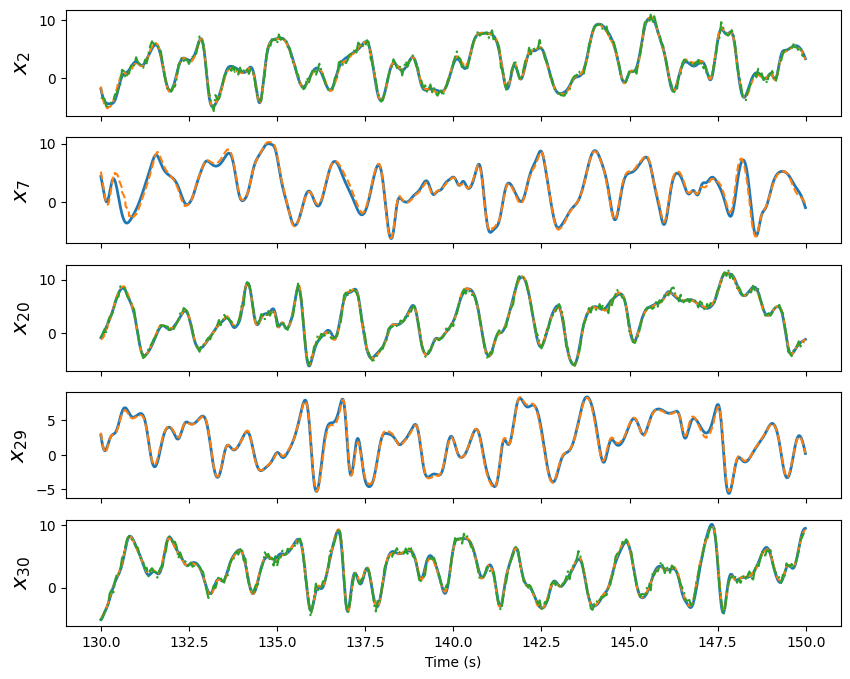

In [14]:
# Plot them all
example_indices = np.sort(np_rng.choice(np.arange(system_dim),5, replace=False))
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 8))
for i, ax in enumerate(axes):
    j = example_indices[i]
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run', lw=2)
    ax.plot(nr_test.times[:out_statevec.time_dim], out_statevec.values[:, j],
        label='DA', ls='--', lw=1.5)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96_test.times, obs_vec_l96_test.values[:, obs_vec_l96.location_indices[0]==j],
                label='Observations', lw=1.5, ls='-.')
    ax.set_ylabel(r'$x_{{{:d}}}$'.format(j), fontsize = 16)
    if j ==0:
        ax.legend()
ax.set_xlabel('Time (s)')        
plt.show()